In [ ]:
import os
from itertools import pairwise
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import math, copy, time
import matplotlib.pyplot as plt

In [2]:
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

# Embeddings and Positional Encoding

In [ ]:
class Embeddings(nn.Module):
    def __init__(self, d_model: int, vocab: int):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model
    
    def forward(self, x):
        # shape of x: [b, l]
        # shape of output: [b, l, d]
        return self.lut(x) * math.sqrt(self.d_model)

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float, max_len: int=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, d_model)
        
        # shape of position: [max_len, 1]
        position = torch.arange(0, max_len).unsqueeze(1)
        
        # shape of div_term: [d_model // 2]
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        
        # shape of pe: [1, max_len, d_model]
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # shape of x: [b, l, d]
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

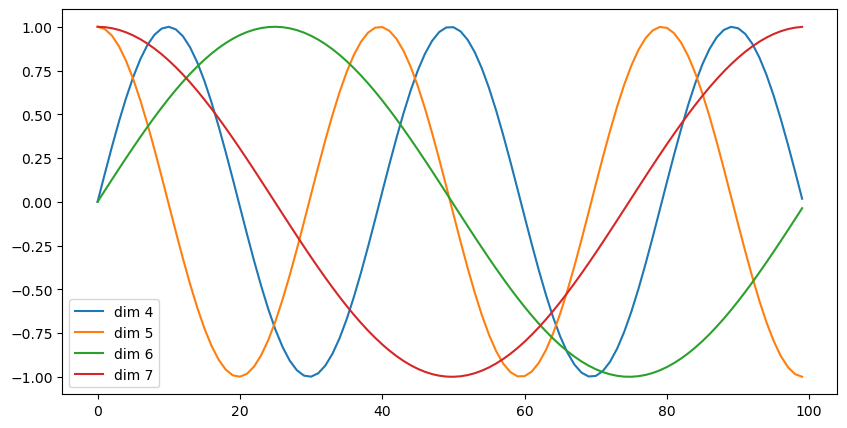

In [5]:
plt.figure(figsize=(10, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(torch.zeros(1, 100, 20))
plt.plot(np.arange(100), y[0, :, 4:8].numpy())
plt.legend([f"dim {p}" for p in [4, 5, 6, 7]])
plt.show()

# Scale Dot Production Attention and Multi-Head Attention

In [6]:
def subsequent_mask(size):
    attn_shape = (1, size, size)
    return torch.triu(torch.ones(attn_shape), 1).type(torch.uint8) == 0

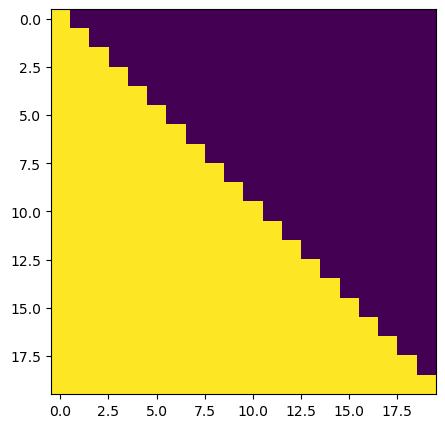

In [7]:
mask = subsequent_mask(20)[0]
plt.figure(figsize=(5, 5))
plt.imshow(mask)
plt.show()
# print(torch.triu(torch.ones(1, 5, 5), 1).type(torch.uint8))
# print(mask)

In [8]:
mask = subsequent_mask(5)
scores = torch.ones(3, 5, 5)
scores = scores.masked_fill(mask == 0, -1e9)
print(mask, '\n', scores)

tensor([[[ True, False, False, False, False],
         [ True,  True, False, False, False],
         [ True,  True,  True, False, False],
         [ True,  True,  True,  True, False],
         [ True,  True,  True,  True,  True]]]) 
 tensor([[[ 1.0000e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
         [ 1.0000e+00,  1.0000e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09],
         [ 1.0000e+00,  1.0000e+00,  1.0000e+00, -1.0000e+09, -1.0000e+09],
         [ 1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00, -1.0000e+09],
         [ 1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00]],

        [[ 1.0000e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
         [ 1.0000e+00,  1.0000e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09],
         [ 1.0000e+00,  1.0000e+00,  1.0000e+00, -1.0000e+09, -1.0000e+09],
         [ 1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00, -1.0000e+09],
         [ 1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00]],

  

In [9]:
def attention(query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask: torch.Tensor=None, dropout: nn.Dropout=None):
    # shape of query: [b, nq, d_k] or [b, h, nq, d_k]
    # shape of key: [b, n, d_k] or [b, h, n, d_k]
    # shape of value: [b, n, d_v] or [b, h, n, d_v]
    d_k = query.size(-1)
    # shape of scores: [b, nq, n] or [b, h, nq, n]
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    # shape of mask: [b, 1 or nq, n] or [b, 1, 1 or nq, n]
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [10]:
class MultiHeadAttention(nn.Module):
    def __init__(self, h: int, d_model: int, dropout: float=0.1):
        super(MultiHeadAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, query, key, value, mask: torch.Tensor=None):
        # add a dimension for Multi-Head attention
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        query, key, value = [lin(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
                             for lin, x in zip(self.linears, (query, key, value))]
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

# Add & Norm

In [11]:
class SublayerConnection(nn.Module):
    def __init__(self, size: int, dropout: float):
        super(SublayerConnection, self).__init__()
        self.norm = nn.LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

# Positionwise FFN

In [12]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

# Encoder

In [13]:
class EncoderLayer(nn.Module):
    def __init__(self, size: int, self_attn: MultiHeadAttention, feed_forward: PositionwiseFeedForward, dropout: float):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size
        
    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [14]:
class Encoder(nn.Module):
    def __init__(self, layer: EncoderLayer, N: int):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = nn.LayerNorm(layer.size)
        
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

# Decoder

In [15]:
class DecoderLayer(nn.Module):
    def __init__(self, size: int, self_attn: MultiHeadAttention, src_attn: MultiHeadAttention, feed_forward: PositionwiseFeedForward, dropout: float):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

In [16]:
class Decoder(nn.Module):
    def __init__(self, layer: DecoderLayer, N: int):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = nn.LayerNorm(layer.size)
    
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

# EncoderDecoder

In [17]:
class Generator(nn.Module):
    def __init__(self, d_model: int, vocab: int):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)
    
    def forward(self, x):
        return self.proj(x)

In [18]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder: Encoder, decoder: Decoder, src_embed, tgt_embed, generator: Generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
    
    def forward(self, src, tgt, src_mask, tgt_mask) -> torch.Tensor:
        return self.generator(self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask))
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [19]:
def make_model(src_vocab: int, tgt_vocab: int, N: int=6, d_model: int=512, d_ff: int=2048, h: int=8, dropout: float=0.1) -> EncoderDecoder:
    c = copy.deepcopy
    attn = MultiHeadAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab)
    )
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

# Data

In [20]:
from collections import Counter
class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        """Defined in :numref:`sec_text-sequence`"""
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        counter = Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']

In [21]:
import requests
import zipfile
import tarfile

def download(url: str, folder='../data', sha1_hash=None):
    os.makedirs(folder, exist_ok=True)
    fname = os.path.join(folder, url.split('/')[-1])
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def extract(filename: str, folder=None):
    base_dir = os.path.dirname(filename)
    _, ext = os.path.splitext(filename)
    assert ext in ('.zip', '.tar', '.gz'), 'Only support zip/tar files'
    if ext == '.zip':
        fp = zipfile.ZipFile(filename, 'r')
    else:
        fp = tarfile.open(filename, 'r')
    if folder is None:
        folder = base_dir
    fp.extractall(folder)

def load_data():
    DATA_DIR = os.path.join('..', 'data')
    if not os.path.exists(DATA_DIR):
        os.mkdir(DATA_DIR)
    if not os.path.exists(os.path.join(DATA_DIR, 'fra-eng')):
        extract(download('http://d2l-data.s3-accelerate.amazonaws.com/fra-eng.zip'))
    with open ('../data/fra-eng/fra.txt', encoding='utf-8') as f:
        return f.read()

def preprocess(text: str):
    text = text.replace('\u202f', ' ').replace('\xa0', ' ')
    no_space = lambda char, prev_char: char in ',.!?' and prev_char != ' '
    out = [' ' + ch if no_space(ch, prev) else ch for prev, ch in pairwise(' ' + text.lower())]
    return ''.join(out)

def tokenize(text: str, max_examples: int=None):
    src, tgt = [], []
    for i, line in enumerate(text.split('\n')[:max_examples]):
        parts = line.split('\t')
        if len(parts) == 2:
            src.append([t for t in parts[0].split(' ') if t])
            tgt.append([t for t in parts[1].split(' ') if t] + ['<eos>'])
    return src, tgt

def build_array(sentences: list[list[str]], vocab: Vocab, num_steps: int, is_tgt: bool=False):
    pad_or_trim = lambda seq: seq[:num_steps] if len(seq) > num_steps else seq + ['<pad>'] * (num_steps - len(seq))
    sentences = [pad_or_trim(s) for s in sentences]
    if is_tgt:
        sentences = [['<bos>'] + s for s in sentences]
    if vocab is None:
        vocab = Vocab(sentences, min_freq=2)
    return torch.tensor([vocab[s] for s in sentences]), vocab

def load_fra_eng(max_examples: int=None):
    raw_text = load_data()
    text = preprocess(raw_text)
    return tokenize(text, max_examples)

class MTFraEng(Dataset):
    def __init__(self, max_examples: int=None, max_len: int=20, src_vocab: Vocab=None, tgt_vocab: Vocab=None):
        super(MTFraEng, self).__init__()
        self.num_steps = max_len
        src, tgt = load_fra_eng(max_examples)
        self.src, self.src_vocab = build_array(src, src_vocab, max_len)
        self.tgt, self.tgt_vocab = build_array(tgt, tgt_vocab, max_len, True)
        
    def __getitem__(self, index):
        return self.src[index], self.tgt[index]

    def __len__(self):
        return len(self.src)

# Batches and Masking

In [22]:
class Batch:
    def __init__(self, src: torch.Tensor, tgt: torch.Tensor, src_pad: int=0, tgt_pad: int=0):
        # shape of src: [b, l]
        # shape of tgt: [b, l]
        self.src = src
        self.src_mask = (src != src_pad).unsqueeze(-2)
        if tgt is not None:
            self.tgt = tgt[:, :-1]
            self.tgt_y = tgt[:, 1:]
            self.tgt_mask = self.make_std_mask(self.tgt, tgt_pad)
            self.tgt_y_mask = (self.tgt_y != tgt_pad).reshape(-1)
            self.ntokens = (self.tgt_y != tgt_pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt: torch.Tensor, pad: int):
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & subsequent_mask(tgt.size(-1)).type_as(tgt_mask)
        return tgt_mask

# Train

In [23]:
num_train, num_val = 4096, 1024
batch_size = 32
dataset = MTFraEng(max_examples=num_train + num_val)
src_pad, tgt_pad = dataset.src_vocab['<pad>'], dataset.tgt_vocab['<pad>']
data_train, data_val = random_split(dataset, [num_train, num_val])
loader_train = DataLoader(data_train, batch_size, shuffle=True)
loader_val = DataLoader(data_val, batch_size, shuffle=False)

In [24]:
d_model, N, dropout = 256, 2, 0.2
d_ff, h = 64, 4
max_epochs = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = make_model(len(dataset.src_vocab), len(dataset.tgt_vocab), N, d_model, d_ff, h, dropout).to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [25]:
def loss(Y_hat: torch.Tensor, Y: torch.Tensor, mask: torch.Tensor):
    l = F.cross_entropy(Y_hat, Y, reduction='none')
    return (l * mask).sum()

In [26]:
for epoch in range(max_epochs):
    model.train()
    train_loss = train_count = 0
    for src, tgt in loader_train:
        src, tgt = src.to(device), tgt.to(device)
        batch = Batch(src, tgt, src_pad, tgt_pad)
        Y_hat: torch.Tensor = model(batch.src, batch.tgt, batch.src_mask, batch.tgt_mask)
        l = loss(Y_hat.contiguous().view(-1, Y_hat.size(-1)), batch.tgt_y.contiguous().view(-1), batch.tgt_y_mask)
        optim.zero_grad()
        with torch.no_grad():
            l.backward()
            optim.step()
            train_loss += l.item()
            train_count += batch.ntokens
    model.eval()
    val_loss = val_count = 0
    for src, tgt in loader_val:
        src, tgt = src.to(device), tgt.to(device)
        batch = Batch(src, tgt, src_pad, tgt_pad)
        with torch.no_grad():
            Y_hat: torch.Tensor = model(batch.src, batch.tgt, batch.src_mask, batch.tgt_mask)
            l = loss(Y_hat.contiguous().view(-1, Y_hat.size(-1)), batch.tgt_y.contiguous().view(-1), batch.tgt_y_mask)
            val_loss += l.item()
            val_count += batch.ntokens
    print(f'Epoch: {epoch + 1:03d}, Train loss: {train_loss / train_count:.4f}, Val loss: {val_loss / val_count:.4f}')

Epoch: 001, Train loss: 3.4288, Val loss: 2.6522
Epoch: 002, Train loss: 2.3267, Val loss: 2.1750
Epoch: 003, Train loss: 1.8201, Val loss: 1.8823
Epoch: 004, Train loss: 1.4486, Val loss: 1.6815
Epoch: 005, Train loss: 1.1803, Val loss: 1.5576
Epoch: 006, Train loss: 0.9856, Val loss: 1.5258
Epoch: 007, Train loss: 0.8563, Val loss: 1.4869
Epoch: 008, Train loss: 0.7586, Val loss: 1.4880
Epoch: 009, Train loss: 0.6972, Val loss: 1.5043
Epoch: 010, Train loss: 0.6493, Val loss: 1.5171
Epoch: 011, Train loss: 0.6181, Val loss: 1.5507
Epoch: 012, Train loss: 0.5951, Val loss: 1.5868
Epoch: 013, Train loss: 0.5694, Val loss: 1.5707
Epoch: 014, Train loss: 0.5525, Val loss: 1.6210
Epoch: 015, Train loss: 0.5313, Val loss: 1.6085
Epoch: 016, Train loss: 0.5281, Val loss: 1.6586
Epoch: 017, Train loss: 0.5099, Val loss: 1.6401
Epoch: 018, Train loss: 0.4953, Val loss: 1.6319
Epoch: 019, Train loss: 0.4825, Val loss: 1.6433
Epoch: 020, Train loss: 0.4761, Val loss: 1.6828
Epoch: 021, Train lo

# Predict

In [28]:
def greedy_decode(model: EncoderDecoder, src, src_mask, max_len: int, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src)
    for i in range(max_len - 1):
        out = model.decode(memory, src_mask, ys, subsequent_mask(ys.shape[1]).type_as(src))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word[0]
        ys = torch.cat([ys, torch.ones(1, 1).type_as(src).fill_(next_word)], dim=1)
    return ys

In [31]:
for src, tgt in loader_val:
    src, tgt = src[:1].to(device), tgt.to(device)
    batch = Batch(src, tgt, src_pad, tgt_pad)
    out = greedy_decode(model, batch.src, batch.src_mask, max_len=20, start_symbol=dataset.tgt_vocab['<bos>'])
    print("\nTranslation:")
    for i in range(1, out.size(1)):
        sym = dataset.tgt_vocab.idx_to_token[out[0, i]]
        if sym == '<eos>':
            break
        print(sym, end=' ')
    print("\nTarget:")
    for i in range(1, batch.tgt.size(1)):
        sym = dataset.tgt_vocab.idx_to_token[batch.tgt[0, i]]
        if sym == '<eos>':
            break
        print(sym, end=' ')


Translation:
oublie-le ! 
Target:
oubliez-le . 
Translation:
tom est mort . 
Target:
tom est mort . 
Translation:
il a un <unk> . 
Target:
il a <unk> un <unk> . 
Translation:
ne <unk> pas ! 
Target:
ne <unk> pas ! 
Translation:
nous sommes <unk> . 
Target:
nous allons bien . 
Translation:
je <unk> . 
Target:
<unk> . 
Translation:
qui t'a envoyée ? 
Target:
qui vous a envoyée ? 
Translation:
c'est la vie <unk> ! 
Target:
c'est la vie ! 
Translation:
j'ai confectionné ceux-ci . 
Target:
j'ai fait ceux-ci . 
Translation:
est-ce que tu captes ? 
Target:
tu <unk> ? 
Translation:
j'étais brûlée . 
Target:
j'ai été brûlée . 
Translation:
prenez une partie . 
Target:
tourne à <unk> . 
Translation:
<unk> ? 
Target:
<unk> <unk> ? 
Translation:
arrêtez ! 
Target:
arrête ! 
Translation:
ça sent mauvais . 
Target:
ça pue . 
Translation:
je suis malade . 
Target:
je suis malade . 
Translation:
venez chez nous ! 
Target:
viens chez nous ! 
Translation:
sois juste ! 
Target:
soyez <unk> ! 
Translatio

In [32]:
torch.save(model.state_dict(), 'model.pth')

In [33]:
for src, tgt in loader_train:
    src, tgt = src[:1].to(device), tgt.to(device)
    batch = Batch(src, tgt, src_pad, tgt_pad)
    out = greedy_decode(model, batch.src, batch.src_mask, max_len=20, start_symbol=dataset.tgt_vocab['<bos>'])
    print("Translation:")
    for i in range(1, out.size(1)):
        sym = dataset.tgt_vocab.idx_to_token[out[0, i]]
        if sym == '<eos>':
            break
        print(sym, end=' ')
    print("\nTarget:")
    for i in range(1, batch.tgt.size(1)):
        sym = dataset.tgt_vocab.idx_to_token[batch.tgt[0, i]]
        if sym == '<eos>':
            break
        print(sym, end=' ')
    print()

Translation:
attends une seconde ! 
Target:
attends un peu . 
Translation:
j'ai <unk> . 
Target:
j'ai <unk> . 
Translation:
oublie tom . 
Target:
oublie tom . 
Translation:
c'est affreux ! 
Target:
c'est affreux ! 
Translation:
tom <unk> . 
Target:
tom ronfle . 
Translation:
personne n'est parti . 
Target:
personne ne partit . 
Translation:
il s'agit d'un <unk> . 
Target:
il s'agit d'un <unk> . 
Translation:
pourrions-nous nous asseoir ? 
Target:
pourrions-nous nous asseoir ? 
Translation:
arrête de <unk> . 
Target:
arrête de <unk> . 
Translation:
j'en ai terminé . 
Target:
j'en ai terminé . 
Translation:
j'obéirai . 
Target:
j'obéirai . 
Translation:
êtes-vous chez moi ? 
Target:
êtes-vous chez nous ? 
Translation:
viens <unk> . 
Target:
viens <unk> . 
Translation:
allez doucement ! 
Target:
allez doucement ! 
Translation:
je suis mouillé . 
Target:
je suis <unk> . 
Translation:
qui a <unk> ? 
Target:
qui <unk> ? 
Translation:
je suis tellement las ! 
Target:
je suis tellement las ! 
